In [1]:
import numpy as np
import torch
import networkx as nx
from torchvision import transforms

from src.CBN import CausalBayesianNetwork as CBN
import modularised_utils as mut
import Linear_Additive_Noise_Models as lanm
import operations as ops
import evaluation_utils as evut
import params
import torchvision
import random
import joblib

import opt_utils as oput

[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.


In [2]:
experiment = 'cmnist'

# Variable names
D = 'Digit'
C = 'Color'
I = 'Image'

D_ = 'Digit_'
C_ = 'Color_'
I_ = 'Image_'

In [3]:
# Define sample sizes
num_llsamples = params.n_samples[experiment][0] if experiment in params.n_samples else 1000
num_hlsamples = params.n_samples[experiment][1] if experiment in params.n_samples else 1000

In [4]:
class ColorMNISTDataGenerator:
    def __init__(self, image_size=32):
        self.colors = {
            0: (1.0, 0.0, 0.0),  # Red
            1: (1.0, 0.6, 0.0),  # Orange
            2: (0.8, 1.0, 0.0),  # Yellow-Green
            3: (0.2, 1.0, 0.0),  # Green
            4: (0.0, 1.0, 0.4),  # Blue-Green
            5: (0.0, 1.0, 1.0),  # Cyan
            6: (0.0, 0.4, 1.0),  # Light Blue
            7: (0.2, 0.0, 1.0),  # Blue
            8: (0.8, 0.0, 1.0),  # Purple
            9: (1.0, 0.0, 0.6)   # Pink
        }
        
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])
        
        # Load MNIST dataset
        mnist = torchvision.datasets.MNIST('data/', train=True, download=True)
        self.mnist_data = {}
        for i in range(len(mnist)):
            if mnist.targets[i].item() not in self.mnist_data:
                self.mnist_data[mnist.targets[i].item()] = []
            self.mnist_data[mnist.targets[i].item()].append(mnist.data[i])

    def generate_samples(self, n, intervention=None):
        """Generate n samples with optional intervention"""
        # Initialize arrays for samples
        images = []
        digits = []
        colors = []
        
        for _ in range(n):
            # Sample digit and color (with 0.85 correlation)
            u_conf = np.random.randint(10)
            
            if intervention is None:
                digit = u_conf if np.random.random() < 0.85 else np.random.randint(10)
                color = u_conf if np.random.random() < 0.85 else np.random.randint(10)
            else:
                # Get intervention values using the Intervention class interface
                intervention_dict = intervention.vv()
                # Default to random sampling if variable not in intervention
                digit = intervention_dict['digit'] if 'digit' in intervention_dict else (u_conf if np.random.random() < 0.85 else np.random.randint(10))
                color = intervention_dict['color'] if 'color' in intervention_dict else (u_conf if np.random.random() < 0.85 else np.random.randint(10))
            
            # Get MNIST image
            idx = np.random.randint(len(self.mnist_data[digit]))
            img = self.mnist_data[digit][idx]
            
            # Apply color
            color_rgb = self.colors[color]
            img_color = torch.tensor(img).float().unsqueeze(0).repeat(3, 1, 1)
            for c in range(3):
                img_color[c] *= color_rgb[c]
            
            # Transform
            img_final = self.transform(img_color)
            
            # Store samples
            images.append(img_final.flatten().numpy())  # Flatten image to 1D array
            digits.append(digit)
            colors.append(color)
        
        # Convert to numpy arrays
        images = np.array(images)  # Shape: (n, 3072) for 32x32x3 images
        digits = np.array(digits)  # Shape: (n,)
        colors = np.array(colors)  # Shape: (n,)
        
        # Create one-hot encodings
        digits_onehot = np.eye(10)[digits]  # Shape: (n, 10)
        colors_onehot = np.eye(10)[colors]  # Shape: (n, 10)
        
        # Concatenate all features
        # Format: [image features (3072), digit one-hot (10), color one-hot (10)]
        samples = np.concatenate([images, digits_onehot, colors_onehot], axis=1)
        
        return samples  # Shape: (n, 3092)

In [5]:
# Redefine interventions with consistent naming
iota0 = None  # observational
iota1 = ops.Intervention({'digit': 6})
iota2 = ops.Intervention({'digit': 8})
iota3 = ops.Intervention({'digit': 4})
iota4 = ops.Intervention({'color': 7})  # Changed 'Color' to 'color'
iota5 = ops.Intervention({'color': 0})
iota6 = ops.Intervention({'color': 4})
iota7 = ops.Intervention({'digit': 6, 'color': 7})
iota8 = ops.Intervention({'digit': 8, 'color': 0})
iota9 = ops.Intervention({'digit': 4, 'color': 4})

# High-level interventions (eta)
eta0 = None  # observational
eta1 = ops.Intervention({'D_': 6})
eta2 = ops.Intervention({'D_': 8})
eta3 = ops.Intervention({'D_': 4})
eta4 = ops.Intervention({'C_': 7})
eta5 = ops.Intervention({'C_': 0})
eta6 = ops.Intervention({'C_': 4})
eta7 = ops.Intervention({'D_': 6, 'C_': 7})
eta8 = ops.Intervention({'D_': 8, 'C_': 0})
eta9 = ops.Intervention({'D_': 4, 'C_': 4})

# Update omega mapping
omega = {
    iota0: eta0,
    iota1: eta1,
    iota2: eta2,
    iota3: eta3,
    iota4: eta4,
    iota5: eta5,
    iota6: eta6,
    iota7: eta7,
    iota8: eta8,
    iota9: eta9
}

Ill_relevant = list(set(omega.keys()))
Ihl_relevant = list(set(omega.values()))

In [6]:
def get_components(samples):
    """
    Extract image, digit, and color components from samples array
    
    samples shape: (n_samples, 3092) where:
    - images: first 3072 columns (32x32x3 = 3072)
    - digits: next 10 columns (one-hot encoded)
    - colors: last 10 columns (one-hot encoded)
    """
    # Extract components
    images = samples[:, :3072]  # First 3072 columns
    digits_onehot = samples[:, 3072:3082]  # Next 10 columns
    colors_onehot = samples[:, 3082:]  # Last 10 columns
    
    # Convert one-hot back to indices
    digits = np.argmax(digits_onehot, axis=1)
    colors = np.argmax(colors_onehot, axis=1)
    
    # Reshape images to (n_samples, 32, 32, 3)
    images = images.reshape(-1, 3, 32, 32)
    
    return {
        'images': images,
        'digits': digits,
        'colors': colors,
        'digits_onehot': digits_onehot,
        'colors_onehot': colors_onehot
    }

# Visualize some images
import matplotlib.pyplot as plt

def show_samples(components, num_samples=3):
    fig, axes = plt.subplots(1, num_samples, figsize=(2*num_samples, 2))
    
    for i in range(num_samples):
        # Convert from (3,32,32) to (32,32,3) and denormalize
        img = components['images'][i].transpose(1,2,0)
        img = (img + 1) / 2  # Denormalize from [-1,1] to [0,1]
        
        if num_samples == 1:
            ax = axes
        else:
            ax = axes[i]
            
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f'D:{components["digits"][i]}\nC:{components["colors"][i]}')
    
    plt.tight_layout()
    plt.show()

In [7]:
def low_to_high_level(samples):
    """
    Transform low-level samples to high-level by clustering pixels into one variable I.
    D and C remain unchanged as they are already high-level variables.
    
    Args:
    - samples: Low level samples with shape (n_samples, 3072+20) where:
        - First 3072: image pixels (32x32x3)
        - Next 10: digit one-hot (D)
        - Last 10: color one-hot (C)
    """
    # Split into components
    images = samples[:, :3072]  # Image features (32x32x3)
    D = samples[:, 3072:3082]   # Digit one-hot
    C = samples[:, 3082:]       # Color one-hot
    
    # Cluster all pixels into one variable I
    # Here we could use different methods to aggregate pixels into I
    # For example, taking the mean across all pixels
    I = images.mean(axis=1, keepdims=True)  # Simple aggregation
    
    # Concatenate [D, C, I] in that order to match VH = {D, C, I}
    high_level_samples = np.concatenate([D, C, I], axis=1)
    
    return high_level_samples

In [8]:
data_generator = ColorMNISTDataGenerator()

In [9]:
# Generate samples
Dll_samples = {}
for iota in Ill_relevant:
    Dll_samples[iota] = data_generator.generate_samples(num_llsamples, iota)

# Generate high-level samples
Dhl_samples = {}
for eta in Ihl_relevant:
    if eta is not None:
        # Find corresponding low-level intervention
        iota = [i for i, e in omega.items() if e == eta][0]
        # Transform low-level to high-level
        Dhl_samples[eta] = low_to_high_level(Dll_samples[iota])
    else:
        # For observational distribution
        Dhl_samples[eta] = low_to_high_level(Dll_samples[None])

/var/folders/vn/9swzhgj513q7n9gd_4vsbd840000gn/T/ipykernel_42076/1945190664.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_color = torch.tensor(img).float().unsqueeze(0).repeat(3, 1, 1)


In [10]:
from src.CBN import CausalBayesianNetwork

def create_cmnist_graphs():
    # Low-level causal graph (VL)
    ll_edges = [('digit', 'pixels'), ('color', 'pixels')]  # Changed from 'D', 'C' to 'digit', 'color'
    ll_causal_graph = CausalBayesianNetwork(ll_edges)
    
    # High-level causal graph (VH)
    hl_edges = [('D_', 'I_'), ('C_', 'I_')]  # Using D_, C_, I_ for high level as defined earlier
    hl_causal_graph = CausalBayesianNetwork(hl_edges)
    
    return ll_causal_graph, hl_causal_graph

# Create the graphs as CausalBayesianNetwork objects
ll_causal_graph, hl_causal_graph = create_cmnist_graphs()

In [11]:
data_observational_ll = Dll_samples[None]
data_observational_hl = Dhl_samples[None]

In [12]:
ll_endogenous_coeff_dict = mut.get_coefficients(data_observational_ll, ll_causal_graph)
hl_endogenous_coeff_dict = mut.get_coefficients(data_observational_hl, hl_causal_graph)

In [13]:
U_ll, ll_mu_hat, ll_Sigma_hat = mut.lan_abduction(data_observational_ll, ll_causal_graph, ll_endogenous_coeff_dict)
U_hl, hl_mu_hat, hl_Sigma_hat = mut.lan_abduction(data_observational_hl, hl_causal_graph, hl_endogenous_coeff_dict)

In [14]:
LLmodels = {}
for iota in Ill_relevant:
    LLmodels[iota] = lanm.LinearAddSCM(ll_causal_graph, ll_endogenous_coeff_dict, iota)

HLmodels = {}
for eta in Ihl_relevant:
    HLmodels[eta] = lanm.LinearAddSCM(hl_causal_graph, hl_endogenous_coeff_dict, eta)

In [15]:
Ds = {}
for iota in Ill_relevant:
    Ds[iota] = (Dll_samples[iota], Dhl_samples[omega[iota]])

In [16]:
joblib.dump((ll_causal_graph, Ill_relevant), f"data/{experiment}/LL.pkl")
joblib.dump(ll_endogenous_coeff_dict, f"data/{experiment}/ll_coeffs.pkl")

joblib.dump((hl_causal_graph, Ihl_relevant), f"data/{experiment}/HL.pkl")
joblib.dump(hl_endogenous_coeff_dict, f"data/{experiment}/hl_coeffs.pkl")

joblib.dump(Ds, f"data/{experiment}/Ds.pkl")

joblib.dump(omega, f"data/{experiment}/omega.pkl")
joblib.dump((U_hl, hl_mu_hat, hl_Sigma_hat), f"data/{experiment}/exogenous_HL.pkl")

['data/cmnist/exogenous_HL.pkl']

In [17]:
def create_cmnist_structural_matrices(samples, causal_graph, intervention=None):
    """
    Create structural matrices for CMNIST taking into account the partitioned variables
    """
    if intervention is None:
        # Observational case - identity matrix
        if 'pixels' in causal_graph.nodes():  # Low level
            F = np.eye(3092)
        else:  # High level
            F = np.eye(21)
    else:
        # Interventional case
        if 'pixels' in causal_graph.nodes():  # Low level
            F = np.eye(3092)
            # If digit is intervened
            if 'digit' in intervention.vv():
                # Zero out influence of digit on pixels
                F[0:3072, 3072:3082] = 0
            # If color is intervened
            if 'color' in intervention.vv():
                # Zero out influence of color on pixels
                F[0:3072, 3082:3092] = 0
        else:  # High level
            F = np.eye(21)
            # If D_ is intervened
            if 'D_' in intervention.vv():
                # Zero out influence of D_ on I_
                F[20, 0:10] = 0
            # If C_ is intervened
            if 'C_' in intervention.vv():
                # Zero out influence of C_ on I_
                F[20, 10:20] = 0
    
    return F

class CMNISTLinearSCM:
    def __init__(self, F):
        self.F = F
    
    def _compute_reduced_form(self):
        return self.F

# Create structural matrices for both levels
LLmodels = {}
for iota in Ill_relevant:
    F = create_cmnist_structural_matrices(Dll_samples[iota], ll_causal_graph, iota)
    LLmodels[iota] = CMNISTLinearSCM(F)

HLmodels = {}
for eta in Ihl_relevant:
    F = create_cmnist_structural_matrices(Dhl_samples[eta], hl_causal_graph, eta)
    HLmodels[eta] = CMNISTLinearSCM(F)

# Now this should work
L_matrices = oput.compute_struc_matrices(LLmodels, Ill_relevant)
H_matrices = oput.compute_struc_matrices(HLmodels, Ihl_relevant)

In [18]:
joblib.dump(LLmodels, f"data/{experiment}/LLmodels.pkl")
joblib.dump(HLmodels, f"data/{experiment}/HLmodels.pkl")

['data/cmnist/HLmodels.pkl']

In [19]:
def compute_empirical_radius(N, eta, c1=1.0, c2=1.0, alpha=2.0, m=3):
    """
    Compute epsilon_N(eta) for empirical Wasserstein case.

    Parameters:
    - N: int, number of samples
    - eta: float, confidence level (0 < eta < 1)
    - c1: float, constant from theorem (default 1.0, adjust if needed)
    - c2: float, constant from theorem (default 1.0, adjust if needed)
    - alpha: float, light-tail exponent (P[exp(||ξ||^α)] ≤ A)
    - m: int, ambient dimension

    Returns:
    - epsilon: float, the concentration radius
    """
    assert 0 < eta < 1, "eta must be in (0,1)"
    threshold = np.log(c1 / eta) / c2
    if N >= threshold:
        exponent = min(1/m, 0.5)
    else:
        exponent = 1 / alpha

    epsilon = (np.log(c1 / eta) / (c2 * N)) ** exponent
    return epsilon


In [20]:
l = len(ll_causal_graph.nodes())
h = len(hl_causal_graph.nodes())

In [21]:
ll_bound = round(compute_empirical_radius(N=num_llsamples, eta=0.05, c1=1000.0, c2=1.0, alpha=2.0, m=l), 3)
hl_bound = round(compute_empirical_radius(N=num_hlsamples, eta=0.05, c1=1000.0, c2=1.0, alpha=2.0, m=h), 3)


In [23]:
epsilon, delta = ll_bound, hl_bound

eta_max = 0.001
eta_min = 0.001

max_iter = 1000
num_steps_min = 5
num_steps_max = 2

robust_L = True 
robust_H = True

initialization = 'random'

tol  = 1e-4
seed = 23

In [24]:
opt_params_erica = {
                        'U_L': U_ll,
                        'U_H': U_hl,
                        'L_models': LLmodels,
                        'H_models': HLmodels,
                        'omega': omega,
                        'epsilon': epsilon,
                        'delta': delta,
                        'eta_min': eta_min,
                        'eta_max': eta_max,
                        'num_steps_min': num_steps_min,
                        'num_steps_max': num_steps_max,
                        'max_iter': max_iter,
                        'tol': tol,
                        'seed': seed,
                        'robust_L': robust_L,
                        'robust_H': robust_H,
                        'initialization': initialization,
                        'experiment': experiment
                    }

In [25]:
import opt_utils as oput
import tqdm
import os
import joblib
import torch
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import torch
import time
import os
import ot


import networkx as nx
from tqdm import tqdm
import joblib

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn as nn

from src.CBN import CausalBayesianNetwork as CBN
import operations as ops
import modularised_utils as mut
import evaluation_utils as evut

In [26]:
def run_empirical_erica_optimization(U_L, U_H, L_models, H_models, omega, epsilon, delta, eta_min, eta_max,
                                    num_steps_min, num_steps_max, max_iter, tol, seed, robust_L, robust_H, initialization, experiment):
    
    torch.manual_seed(seed)
    Ill = list(L_models.keys())

    method  = 'erica' if robust_L or robust_H else 'enrico'
    num_steps_min = 1 if method == 'enrico' else num_steps_min

    # Convert inputs to torch tensors
    U_L = torch.as_tensor(U_L, dtype=torch.float32)
    U_H = torch.as_tensor(U_H, dtype=torch.float32)
    
    # Get dimensions
    N, l = U_L.shape
    _, h = U_H.shape
    
    # Initialize variables
    T     = torch.randn(h, l, requires_grad=True)
    if initialization == 'random':
        Theta = torch.randn(N, l, requires_grad=True)
        Phi   = torch.randn(N, h, requires_grad=True)

    elif initialization == 'projected':
        Theta = oput.init_in_frobenius_ball((N, l), epsilon)
        Phi   = oput.init_in_frobenius_ball((N, h), delta)

    
    # Create optimizers
    optimizer_T   = torch.optim.Adam([T], lr=eta_min)
    optimizer_max = torch.optim.Adam([Theta, Phi], lr=eta_max)
    
    prev_T_objective = float('inf')
    
    for iteration in tqdm(range(max_iter)):
         
        objs_T, objs_max = [], []
        # Step 1: Minimize with respect to T
        for _ in range(num_steps_min):
            optimizer_T.zero_grad()
            T_objective = oput.empirical_objective(U_L, U_H, T, Theta, Phi, L_models, H_models, Ill, omega)
            objs_T.append(T_objective.item())
            T_objective.backward()
            optimizer_T.step()
        #plot_progress(objs_T, 'T')
        # Step 2: Maximize with respect to Theta and Phi
        if method == 'erica':
            for _ in range(num_steps_max):
                optimizer_max.zero_grad()
                max_objective = -oput.empirical_objective(U_L, U_H, T, Theta, Phi, L_models, H_models, Ill, omega)
                max_objective.backward()
                optimizer_max.step()
                
                # Project onto constraint sets
                with torch.no_grad():
                    Theta.data = oput.project_onto_frobenius_ball(Theta, epsilon)
                    Phi.data   = oput.project_onto_frobenius_ball(Phi, delta)

                mobj = oput.empirical_objective(U_L, U_H, T, Theta, Phi, L_models, H_models, Ill, omega)
                objs_max.append(mobj.item())

        with torch.no_grad():
            current_T_objective = T_objective.item()
            if abs(prev_T_objective - current_T_objective) < tol:
                print(f"Converged at iteration {iteration + 1}")
                break
            prev_T_objective = current_T_objective
            
    T       = T.detach().numpy()
    paramsL = {'pert_U': Theta.detach().numpy(), 'radius_worst': epsilon,
                    'pert_hat': U_L, 'radius': epsilon}
    paramsH = {'pert_U': Phi.detach().numpy(), 'radius_worst': delta,
                    'pert_hat': U_H, 'radius': delta}
    
    if method == 'erica':
        
        radius_worst_L          = evut.compute_empirical_worst_case_distance(paramsL)
        paramsL['radius_worst'] = radius_worst_L

        radius_worst_H          = evut.compute_empirical_worst_case_distance(paramsH)
        paramsH['radius_worst'] = radius_worst_H

    opt_params = {'L': paramsL, 'H': paramsH}

    save_dir = f"data/{experiment}/{method}"
    os.makedirs(save_dir, exist_ok=True)

    joblib.dump(opt_params, f"data/{experiment}/{method}/opt_params.pkl")

    return opt_params, T

In [27]:
# Define different epsilon=delta values
eps_delta_values     = [8, ll_bound, 1, 2, 4]
diroca_train_results_empirical = {}

# For each epsilon=delta value
for eps_delta in eps_delta_values:
    print(f"Training for ε=δ = {eps_delta}")
    # Update theta parameters
    if eps_delta == ll_bound:
        opt_params_erica['epsilon'] = ll_bound
        opt_params_erica['delta']   = hl_bound
    
    else:
        opt_params_erica['epsilon'] = eps_delta
        opt_params_erica['delta']   = eps_delta
    
    # Run ERICA optimization
    params_empirical, T_empirical = run_empirical_erica_optimization(**opt_params_erica)
    
    # Store results including optimization parameters and transformation matrix
    if eps_delta == ll_bound:
        diroca_train_results_empirical['T_'+str(ll_bound)+'-'+str(hl_bound)] = {
                                                    'optimization_params': params_empirical,
                                                    'T_matrix': T_empirical
                                                }
    else:
        diroca_train_results_empirical['T_'+str(eps_delta)] = {
                                                    'optimization_params': params_empirical,
                                                    'T_matrix': T_empirical
                                                }

print("\nTraining completed. T matrices stored in trained_results dictionary.")
print("Available ε=δ values:", list(diroca_train_results_empirical.keys()))

Training for ε=δ = 8


100%|██████████| 1000/1000 [40:20<00:00,  2.42s/it]


Training for ε=δ = 0.215


 46%|████▌     | 459/1000 [19:12<22:38,  2.51s/it]


Converged at iteration 460
Training for ε=δ = 1


100%|██████████| 1000/1000 [40:52<00:00,  2.45s/it]


Training for ε=δ = 2


100%|██████████| 1000/1000 [39:59<00:00,  2.40s/it]


Training for ε=δ = 4


 85%|████████▌ | 854/1000 [32:59<05:38,  2.32s/it]

Converged at iteration 855

Training completed. T matrices stored in trained_results dictionary.
Available ε=δ values: ['T_8', 'T_0.215-0.215', 'T_1', 'T_2', 'T_4']


In [28]:
params_enrico, T_enrico = oput.run_empirical_erica_optimization(**{**opt_params_erica, 'robust_L': False, 'robust_H': False})

100%|██████████| 1000/1000 [04:35<00:00,  3.63it/s]


In [29]:
diroca_train_results_empirical['T_0.00'] = {
                                'optimization_params': params_enrico,
                                'T_matrix': T_enrico
                            }

In [30]:
opt_params_bary = {
                        'U_ll_hat':U_ll,
                        'U_hl_hat':U_hl,
                        'L_matrices':L_matrices,
                        'H_matrices':H_matrices,
                        'max_iter':max_iter,
                        'tol':tol,
                        'seed':seed
                    }
                                    

In [31]:

T_bary = oput.run_empirical_bary_optim(**opt_params_bary)
params_bary = {'L':{}, 'H':{}}

100%|██████████| 1000/1000 [00:07<00:00, 139.76it/s]


In [32]:
diroca_train_results_empirical['T_b'] = {
                                'optimization_params': params_bary,
                                'T_matrix': T_bary
                            }

In [33]:
opt_params_smooth = {
                        'U_L': U_ll,
                        'U_H': U_hl,
                        'L_models': LLmodels,
                        'H_models': HLmodels,
                        'omega': omega,
                        'eta_min': eta_min,
                        'num_steps_min': num_steps_min,
                        'max_iter': 300,
                        'tol': tol,
                        'seed': seed,
                        'noise_sigma': 0.1,
                        'num_noise_samples': 10
                        }

In [34]:
params_smooth, T_smooth = oput.run_empirical_smooth_optimization(**opt_params_smooth)

100%|██████████| 300/300 [1:25:01<00:00, 17.01s/it]


In [35]:
diroca_train_results_empirical['T_s'] = {
                                'optimization_params': params_smooth,
                                'T_matrix': T_smooth
                            }

In [36]:
# First run the Abs-LiNGAM algorithm to get the transformation matrices
abslingam_results = evut.run_abs_lingam_complete(data_observational_ll, data_observational_hl)

# Add these results to your T_results_emp dictionary
diroca_train_results_empirical['T_pa'] = {'optimization_params':{'L':{'pert_U':U_ll},'H':{'pert_U':U_hl}}, 'T_matrix': abslingam_results['Perfect']['T'].T}
diroca_train_results_empirical['T_na'] = {'optimization_params':{'L':{'pert_U':U_ll},'H':{'pert_U':U_hl}}, 'T_matrix': abslingam_results['Noisy']['T'].T}


In [37]:
joblib.dump(diroca_train_results_empirical, f"data/{experiment}/diroca_train_results_empirical.pkl")

['data/cmnist/diroca_train_results_empirical.pkl']

In [38]:
print("Done")

Done


# ADJUST FOR mod_noise()

In [49]:
def mod_noise(U_samples, intervention):
    """
    Modify exogenous noise for exact interventions by setting the entire column 
    to the intervention value for each intervened variable.
    
    Args:
        U_samples: Original noise samples (n_samples x n_variables)
        intervention: Intervention object or None
    """
    U_modified = U_samples.copy()
    
    if intervention is not None:
        # Get dictionary of interventions
        intervention_dict = intervention.vv()
        
        # For each intervened variable
        for var in intervention.Phi():  # Use Phi() to get variables
            value = intervention_dict[var]
            
            # If var is already an integer index, use it directly
            if isinstance(var, (int, np.integer)):
                var_idx = var
            # Otherwise try to get the name or string representation
            else:
                var_idx = str(var)
                # Map variable name to index based on your convention
                # For example, if 'CG' maps to 0, 'ML1' to 1, etc.
                var_map = {'CG': 0, 'ML1': 1, 'ML2': 2, 'S': 0, 'T': 1}
                var_idx = var_map.get(var_idx, 0)  # default to 0 if not found
            
            # Set entire column to intervention value
            U_modified[:, var_idx] = value
    
    return U_modified

In [50]:
T_results_emp = diroca_train_results_empirical

In [51]:
data = evut.generate_empirical_data(LLmodels, HLmodels, omega, U_ll, U_hl)

In [52]:
test_observ        = True
test_interv        = True 
metric             = 'fro'
num_iter           = 20

if test_observ and test_interv:
    test_data = data

elif test_observ:
    test_data = {None: data[None]}

elif test_interv:
    test_data = {k: v for k, v in data.items() if k is not None}

In [53]:
results_single = {method: {'errors': [], 'mean': 0, 'ci': 0} for method in T_results_emp.keys()}

for name, method_data in T_results_emp.items():
    T = method_data['T_matrix']
    errors = []  # Store errors for each intervention
    scale_factor = 1/np.sqrt(len(Ill_relevant))

    for iota in Ill_relevant:
        L_i = LLmodels[iota].F
        H_i = HLmodels[omega[iota]].F
        if iota is not None:
            D_l = L_i @ mod_noise(U_ll, iota).T
            D_h = H_i @ mod_noise(U_hl, omega[iota]).T
        else:
            D_l = L_i @ U_ll.T
            D_h = H_i @ U_hl.T
        
        base_norm = D_l#/ np.linalg.norm(D_l, 'fro')
        abst_norm = D_h#/ np.linalg.norm(D_h, 'fro')
        
        tau_base = T @ base_norm
        dist = evut.compute_empirical_distance(tau_base, abst_norm, 'fro')
        errors.append(dist)  # Store individual errors

    # Calculate mean and CI
    mean_error = np.mean(errors)
    std_error = np.std(errors)
    ci = 1.96 * std_error

    # Store all statistics
    results_single[name] = {
        'errors': errors,
        'mean': mean_error,
        'ci': ci
    }

# Scale the final results
max_mean = max(v['mean'] for v in results_single.values())
scale_factor = 1/max_mean

# # Scale means and CIs
# for method in results_single:
#     results_single[method]['mean'] *= scale_factor
#     results_single[method]['ci'] *= scale_factor

# Sort by mean error
results_single = dict(sorted(results_single.items(), key=lambda x: x[1]['mean']))

# Print results
print("\n" + "="*100)
print(f"{'Method':<15} {'Error (mean ± CI)':<35}")
print("="*100)

for method, stats in results_single.items():
    print(f"{method:<15} {stats['mean']:>8.4f} ± {stats['ci']:<8.4f}")


Method          Error (mean ± CI)                  
T_1              44.9436 ± 48.4301 
T_2              48.4048 ± 59.7381 
T_8              58.6933 ± 54.1034 
T_4              80.6837 ± 73.9793 
T_0.215-0.215    97.6354 ± 99.4977 
T_pa            131.8430 ± 169.2366
T_na            131.8566 ± 169.2583
T_0.00          363.5993 ± 319.1192
T_s             599.2720 ± 727.0430
T_b             604.0219 ± 713.2755


In [54]:
rad_values = np.arange(0.05, 10.05, 2.5).tolist()  
#rad_values = [0.05, 1, 2,3, 4, 5, 10, 50]
sample_forms = ['boundary', 'sample']

In [55]:
hat_dict = {'L': U_ll, 'H': U_hl}

In [56]:
worst = 'T_8'

In [57]:
T_results_emp = diroca_train_results_empirical

In [58]:
T_results_emp['T_pa']['T_matrix']

array([[ 1.68672682e-04,  1.68672682e-04,  1.68672682e-04, ...,
        -2.84412538e-03, -1.03861435e-02,  7.53192766e-03],
       [ 4.15086611e-04,  4.15086611e-04,  4.15086611e-04, ...,
        -6.95343287e-03, -7.19187511e-03,  9.72971663e-03],
       [-5.28483161e-04, -5.28483161e-04, -5.28483161e-04, ...,
         1.11712394e-02,  1.55625221e-02,  5.90980148e-03],
       ...,
       [-5.89535312e-04, -5.89535312e-04, -5.89535312e-04, ...,
        -1.73751734e-01,  6.28728552e-01, -1.43588116e-01],
       [-3.01703843e-04, -3.01703843e-04, -3.01703843e-04, ...,
        -1.36799570e-01, -1.43588116e-01,  6.29393635e-01],
       [ 3.25964682e-04,  3.25964682e-04,  3.25964682e-04, ...,
        -3.31791000e-05, -2.56243280e-05, -2.76067860e-05]])

In [59]:
U_worst_L = T_results_emp[worst]['optimization_params']['L']['pert_U']
U_worst_H = T_results_emp[worst]['optimization_params']['H']['pert_U']


In [60]:
worst_dict = {'L': U_worst_L, 'H': U_worst_H}

In [66]:
center = 'worst'
if center == 'hat':
    center_matrix = hat_dict
elif center == 'worst':
    center_matrix = worst_dict

coverage_type='uniform'

In [95]:
# # First run the Abs-LiNGAM algorithm to get the transformation matrices
# abslingam_results = evut.run_abs_lingam_complete(data_observational_ll, data_observational_hl)

# # Add these results to your T_results_emp dictionary
# T_results_emp['T_pa'] = {'optimization_params':{'L':{'pert_U':U_ll},'H':{'pert_U':U_hl}}, 'T_matrix': abslingam_results['Perfect']['T'].T}
# T_results_emp['T_na'] = {'optimization_params':{'L':{'pert_U':U_ll},'H':{'pert_U':U_hl}}, 'T_matrix': abslingam_results['Noisy']['T'].T}

In [96]:
# Initialize results structure
results = {rad: {
    sample_form: {
        'empirical': {method: [] for method in T_results_emp.keys()}
    } for sample_form in sample_forms
} for rad in rad_values}

for rad in tqdm(rad_values):
    for sample_form in sample_forms:
        for iter_num in range(3):
            pert_L = evut.generate_perturbation_matrix(rad, sample_form, 'L', hat_dict, coverage = coverage_type)
            pert_H = evut.generate_perturbation_matrix(rad, sample_form, 'H', hat_dict, coverage = coverage_type)
            
            for name, method_data in T_results_emp.items():
                T = method_data['T_matrix']
                    
                # total = 0
                # for iota in test_data.keys():

                #     base, abst = test_data[iota]
                    
                #     # Apply perturbations
                #     base_pert = base + pert_L
                #     abst_pert = abst + pert_H
                    
                #     # Normalize
                #     base_norm = base_pert #/ np.linalg.norm(base_pert, 'fro')
                #     abst_norm = abst_pert #/ np.linalg.norm(abst_pert, 'fro')
                    
                #     # Apply method and compute distance
                #     tau_base = base_norm @ T.T
                #     dist = evut.compute_empirical_distance(tau_base, abst_norm, 'fro')
                #     total += dist
                total = 0
                for iota in Ill_relevant:
                    L_i = LLmodels[iota].F
                    H_i = HLmodels[omega[iota]].F
                   
                    D_l = L_i @ (center_matrix['L'].T + pert_L.T)
                    D_h = H_i @ (center_matrix['H'].T + pert_H.T)
                    
                    # Normalize
                    base_norm = D_l #/ np.linalg.norm(D_l, 'fro')
                    abst_norm = D_h #/ np.linalg.norm(D_h, 'fro')
                    
                    tau_base = T @ base_norm
                    dist = evut.compute_empirical_distance(tau_base, abst_norm, 'fro')
                    total += dist
                
                # Store average error for this iteration
                iter_avg = total / len(Ill_relevant)
                results[rad][sample_form]['empirical'][name].append(iter_avg)


# Print results
print("\n" + "="*100)
print(f"{'Radius':<8} {'Sample Form':<12} {'Method':<15} {'Error (mean ± CI)':<35}")
print("="*100)

for rad in rad_values:
    for sample_form in sample_forms:
        print(f"\nRadius: {rad}, Sample form: {sample_form}")
        print("-"*100)
        
        # Create dictionary of method statistics
        method_stats = {}
        for method in T_results_emp.keys():
            errors = results[rad][sample_form]['empirical'][method]
            error_mean = np.mean(errors)
            error_std = np.std(errors)
            ci = 1.96 * error_std
            method_stats[method] = (error_mean, ci)
        
        # Sort methods by mean error (descending order for worst to best)
        sorted_methods = sorted(method_stats.items(), key=lambda x: x[1][0], reverse=True)
        
        # Print sorted results
        for method, (error_mean, ci) in sorted_methods:
            print(f"{rad:<8} {sample_form:<12} {method:<15} "
                  f"{error_mean:>8.4f} ± {ci:<8.4f}")

# Find best methods (already sorted, just take last one)
for rad in rad_values:
    for sample_form in sample_forms:
        print(f"\nRanking for radius {rad}, {sample_form} sampling (worst to best):")
        
        error_means = {method: np.mean(results[rad][sample_form]['empirical'][method])
                      for method in T_results_emp.keys()}
        
        # Sort by error value (descending)
        sorted_methods = sorted(error_means.items(), key=lambda x: x[1], reverse=True)
        
        # Print all methods with ranking
        for rank, (method, error) in enumerate(sorted_methods, 1):
            print(f"{rank}. {method:<15} (error: {error:.4f})")
    

100%|██████████| 4/4 [12:58<00:00, 194.66s/it]


Radius   Sample Form  Method          Error (mean ± CI)                  

Radius: 0.05, Sample form: boundary
----------------------------------------------------------------------------------------------------
0.05     boundary     T_0.00          182.9950 ± 0.0488  
0.05     boundary     T_b             125.0721 ± 0.1017  
0.05     boundary     T_8             107.5062 ± 0.0309  
0.05     boundary     T_0.215-0.215    74.0792 ± 0.0451  
0.05     boundary     T_2              60.9067 ± 0.0301  
0.05     boundary     T_4              45.1285 ± 0.0221  
0.05     boundary     T_1              34.9664 ± 0.0830  
0.05     boundary     T_s              32.8807 ± 0.0668  
0.05     boundary     T_na             17.8121 ± 0.0333  
0.05     boundary     T_pa             17.8119 ± 0.0334  

Radius: 0.05, Sample form: sample
----------------------------------------------------------------------------------------------------
0.05     sample       T_0.00          182.9649 ± 0.0075  
0.05     samp

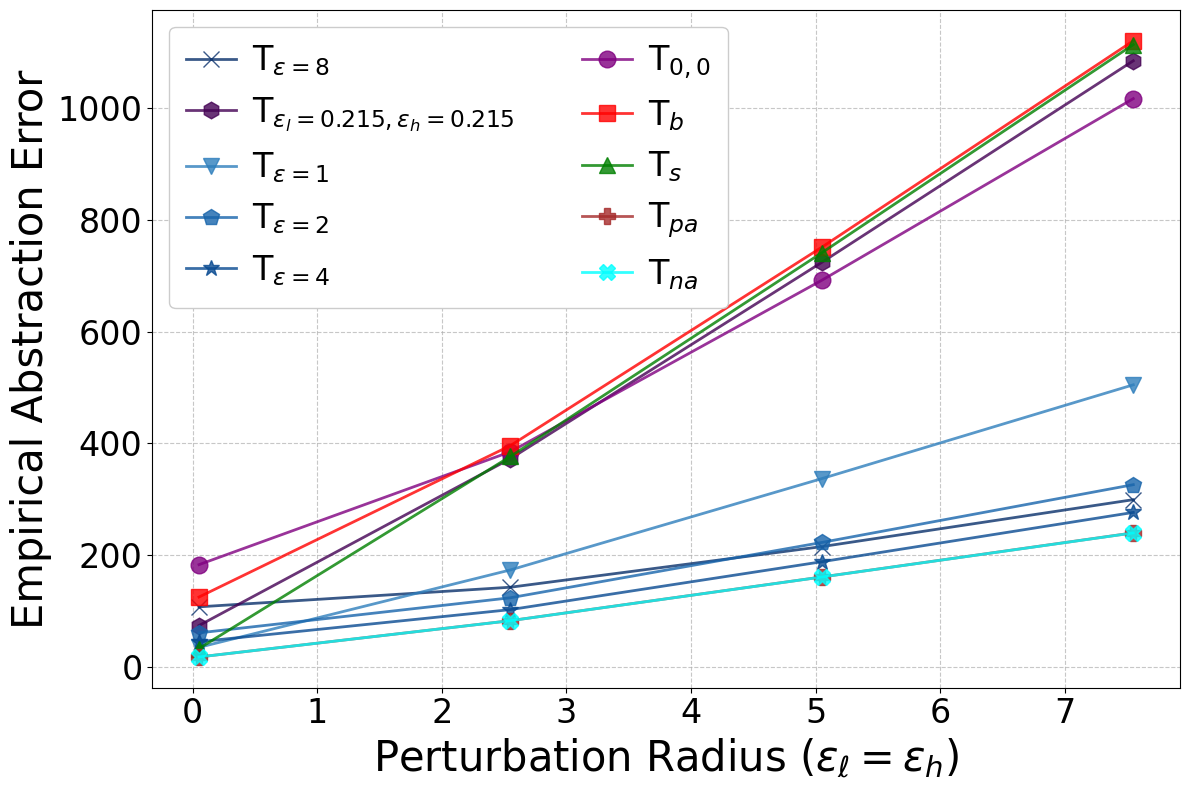

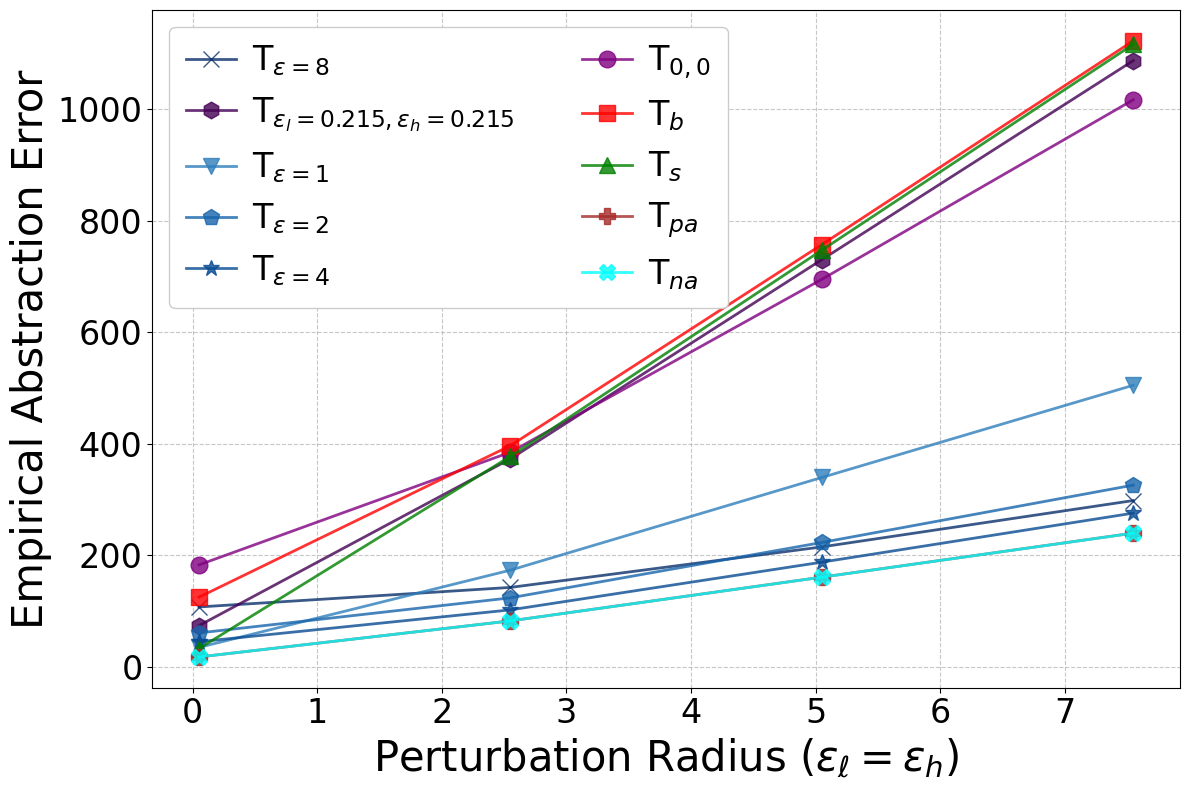

In [97]:
# Example usage with epsilon-delta methods
methods_to_plot = list(T_results_emp.keys())
evut.plot_empirical_abstraction_error(results, methods_to_plot, 'boundary')
evut.plot_empirical_abstraction_error(results, methods_to_plot, 'sample')

In [100]:
# Initialize results structure
results_random = {method: [] for method in T_results_emp.keys()}

#for pert_L, pert_H in tqdm(zip(pert_family_L, pert_family_H)):
for i in tqdm(range(10)):
    rad = random.uniform(0.05, 10.05)
    sample_form = random.choice(['boundary', 'sample'])
    pert_L = evut.generate_perturbation_matrix(rad, sample_form, 'L', hat_dict, coverage = coverage_type).T
    pert_H = evut.generate_perturbation_matrix(rad, sample_form, 'H', hat_dict, coverage = coverage_type).T
    for name, method_data in T_results_emp.items():
        T = method_data['T_matrix']
            
        total = 0
        for iota in Ill_relevant:
            L_i = LLmodels[iota].F
            H_i = HLmodels[omega[iota]].F
            
            D_l = L_i @ (center_matrix['L'].T + pert_L)
            D_h = H_i @ (center_matrix['H'].T + pert_H)
            
            # Normalize
            base_norm = D_l / np.linalg.norm(D_l, 'fro')
            abst_norm = D_h / np.linalg.norm(D_h, 'fro')
            
            tau_base = T @ base_norm
            dist = evut.compute_empirical_distance(tau_base, abst_norm, 'fro')
            total += dist
        
        # Store average error for this iteration
        iter_avg = total / len(Ill_relevant)  # Changed from len(Ill) to len(test_data.keys())
        results_random[name].append(iter_avg)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [05:03<00:00, 30.32s/it]


In [102]:
# Print results with ranking
print("\n" + "="*100)
print(f"{'Rank':<5} {'Method':<15} {'Empirical Distance (mean ± CI)':<35}")
print("="*100)

for sample_form in sample_forms:
    print(f"\nSample form: {sample_form}")
    print("-"*100)
    
    # Calculate means for all methods
    method_means = {method: np.mean(results_random[method]) 
                   for method in T_results_emp.keys()}
    
    # Sort methods by mean error (worst to best)
    sorted_methods = sorted(method_means.items(), key=lambda x: x[1], reverse=True)
    
    # Print ranked results
    for rank, (method, mean) in enumerate(sorted_methods, 1):
        std = np.std(results_random[method])
        print(f"{rank:<5} {method:<15} "
              f"{mean:>8.4f} ± {1.96*std:<8.4f}")

print("="*100)

# Print summary of best and worst methods
for sample_form in sample_forms:
    print(f"\nSummary for {sample_form} sampling:")
    print("-"*100)
    
    # Get sorted methods
    method_means = {method: np.mean(results_random[method]) 
                   for method in T_results_emp.keys()}
    sorted_methods = sorted(method_means.items(), key=lambda x: x[1], reverse=True)
    
    # Print worst and best
    worst_method, worst_error = sorted_methods[0]
    best_method, best_error = sorted_methods[-1]
    
    print(f"Worst method: {worst_method} (error: {worst_error:.4f})")
    print(f"Best method: {best_method} (error: {best_error:.4f})")
    print(f"Error difference: {worst_error - best_error:.4f}")


Rank  Method          Empirical Distance (mean ± CI)     

Sample form: boundary
----------------------------------------------------------------------------------------------------
1     T_b               4.3817 ± 0.6470  
2     T_s               4.2816 ± 0.8972  
3     T_0.215-0.215     4.1973 ± 0.7878  
4     T_0.00            4.0914 ± 0.2326  
5     T_1               1.9858 ± 0.2942  
6     T_2               1.3650 ± 0.0402  
7     T_8               1.3631 ± 0.3714  
8     T_4               1.1583 ± 0.0355  
9     T_pa              1.0018 ± 0.0010  
10    T_na              1.0014 ± 0.0008  

Sample form: sample
----------------------------------------------------------------------------------------------------
1     T_b               4.3817 ± 0.6470  
2     T_s               4.2816 ± 0.8972  
3     T_0.215-0.215     4.1973 ± 0.7878  
4     T_0.00            4.0914 ± 0.2326  
5     T_1               1.9858 ± 0.2942  
6     T_2               1.3650 ± 0.0402  
7     T_8              

In [67]:
# Generate perturbation families
pert_family_L = evut.generate_perturbation_family(
    np.zeros_like(hat_dict['L']),
    k=10,  # Number of perturbations
    r_mu=1.0,
    r_sigma=2.0,
    coverage=coverage_type
)

pert_family_H = evut.generate_perturbation_family(
    np.zeros_like(hat_dict['H']),
    k=10,
    r_mu=1.0,
    r_sigma=2.0,
    coverage=coverage_type
)

In [68]:
# Initialize results structure to store individual distances
results = {
    sample_form: {
        'empirical': {method: [] for method in T_results_emp.keys()}
    } for sample_form in sample_forms
}

for pert_L, pert_H in zip(pert_family_L, pert_family_H):
    for sample_form in sample_forms:
        for name, method_data in T_results_emp.items():
            T = method_data['T_matrix']
            
            # Store individual distances for this perturbation
            distances = []
            
            for iota in Ill_relevant:
                L_i = LLmodels[iota].F
                H_i = HLmodels[omega[iota]].F
                
                
                if iota is not None:
                    pert_noise_L = mod_noise(center_matrix['L'].T, iota) + pert_L.T
                    pert_noise_H = mod_noise(center_matrix['H'].T, omega[iota]) + pert_H.T
                else:
                    pert_noise_L = center_matrix['L'].T + pert_L.T
                    pert_noise_H = center_matrix['H'].T + pert_H.T

                D_l = L_i @ pert_noise_L
                D_h = H_i @ pert_noise_H
                
                # Normalize
                base_norm = D_l #/ np.linalg.norm(D_l, 'fro')
                abst_norm = D_h #/ np.linalg.norm(D_h, 'fro')
                
                tau_base = T @ base_norm
                dist = evut.compute_empirical_distance(tau_base, abst_norm, 'fro')
                distances.append(dist)
            
            # Store all distances for this method and perturbation
            results[sample_form]['empirical'][name].extend(distances)

In [69]:
# Print results with ranking
print("\n" + "="*100)
print(f"{'Rank':<5} {'Method':<15} {'Empirical Distance (mean ± CI)':<35}")
print("="*100)

for sample_form in sample_forms:
    print(f"\nSample form: {sample_form}")
    print("-"*100)
    
    # Calculate means and stds for all methods
    method_stats = {}
    for method in T_results_emp.keys():
        distances = results[sample_form]['empirical'][method]
        mean = np.mean(distances)
        std = np.std(distances)
        method_stats[method] = (mean, std)
    
    # Sort methods by mean error (worst to best)
    sorted_methods = sorted(method_stats.items(), key=lambda x: x[1][0], reverse=True)
    
    # Print ranked results
    for rank, (method, (mean, std)) in enumerate(sorted_methods, 1):
        print(f"{rank:<5} {method:<15} "
              f"{mean:>8.4f} ± {1.96*std:<8.4f}")

print("="*100)

# Print summary of best and worst methods
for sample_form in sample_forms:
    print(f"\nSummary for {sample_form} sampling:")
    print("-"*100)
    
    # Get sorted methods
    method_stats = {method: (np.mean(results[sample_form]['empirical'][method]),
                           np.std(results[sample_form]['empirical'][method]))
                   for method in T_results_emp.keys()}
    sorted_methods = sorted(method_stats.items(), key=lambda x: x[1][0], reverse=True)
    
    # Print worst and best
    worst_method, (worst_error, worst_std) = sorted_methods[0]
    best_method, (best_error, best_std) = sorted_methods[-1]
    
    print(f"Worst method: {worst_method} (error: {worst_error:.4f} ± {1.96*worst_std:.4f})")
    print(f"Best method: {best_method} (error: {best_error:.4f} ± {1.96*best_std:.4f})")
    print(f"Error difference: {worst_error - best_error:.4f}")


Rank  Method          Empirical Distance (mean ± CI)     

Sample form: boundary
----------------------------------------------------------------------------------------------------
1     T_b             7576.1077 ± 123.4938
2     T_s             7575.4157 ± 123.4630
3     T_0.215-0.215   7018.0992 ± 118.5397
4     T_0.00          5864.4015 ± 219.2994
5     T_1             677.9557 ± 16.0636 
6     T_4             571.5596 ± 22.2037 
7     T_2             452.8600 ± 26.1272 
8     T_8             270.3803 ± 50.3459 
9     T_pa            236.9120 ± 2.1892  
10    T_na            235.8291 ± 0.2749  

Sample form: sample
----------------------------------------------------------------------------------------------------
1     T_b             7576.1077 ± 123.4938
2     T_s             7575.4157 ± 123.4630
3     T_0.215-0.215   7018.0992 ± 118.5397
4     T_0.00          5864.4015 ± 219.2994
5     T_1             677.9557 ± 16.0636 
6     T_4             571.5596 ± 22.2037 
7     T_2      

In [70]:
print('done!')

done!
